In [1]:
import gym
from gym import wrappers
import random
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
EPISODES = 200  # number of episodes
EPS_START = 0.9  # e-greedy threshold start value
EPS_END = 0.05  # e-greedy threshold end value
EPS_DECAY = 200  # e-greedy threshold decay
GAMMA = 0.8  # Q-learning discount factor
LR = 0.001  # NN optimizer learning rate
HIDDEN_LAYER = 256  # NN hidden layer size
BATCH_SIZE = 64  # Q-learning batch size

# if gpu is to be used
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor

In [3]:
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []

    def push(self, transition):
        self.memory.append(transition)
        if len(self.memory) > self.capacity:
            del self.memory[0]

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


class Network(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(4, HIDDEN_LAYER)
        self.l2 = nn.Linear(HIDDEN_LAYER, 2)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = self.l2(x)
        return x

In [4]:
env = gym.make('CartPole-v0')
env = wrappers.Monitor(env, '.', force=True)

model = Network()
if use_cuda:
    model.cuda()
memory = ReplayMemory(10000)
optimizer = optim.Adam(model.parameters(), LR)
steps_done = 0
episode_durations = []

In [5]:
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    
        
    if sample > eps_threshold:
        return model(Variable(state).type(FloatTensor)).data.max(1)[1].view(1, 1)
    else:
        return LongTensor([[random.randrange(2)]])

In [6]:
def run_episode(e, environment):
    state = environment.reset()
    steps = 0
    while True:
        environment.render()
        action = select_action(FloatTensor([state]))
        next_state, reward, done, _ = environment.step(action[0, 0].item() )

        # negative reward when attempt ends
        if done:
            reward = -1

        memory.push((FloatTensor([state]),
                     action,  # action is already a tensor
                     FloatTensor([next_state]),
                     FloatTensor([reward])))

        learn()

        state = next_state
        steps += 1

        if done:
            print("{2} Episode {0} finished after {1} steps"
                  .format(e, steps, '\033[92m' if steps >= 195 else '\033[99m'))
            episode_durations.append(steps)
            plot_durations()
            break



In [7]:
def learn():
    if len(memory) < BATCH_SIZE:
        return

    # random transition batch is taken from experience replay memory
    transitions = memory.sample(BATCH_SIZE)
    batch_state, batch_action, batch_next_state, batch_reward = zip(*transitions)

    batch_state = Variable(torch.cat(batch_state))
    batch_action = Variable(torch.cat(batch_action))
    batch_reward = Variable(torch.cat(batch_reward))
    batch_next_state = Variable(torch.cat(batch_next_state))

    # current Q values are estimated by NN for all actions
    current_q_values = model(batch_state).gather(1, batch_action)
    # expected Q values are estimated from actions which gives maximum Q value
    max_next_q_values = model(batch_next_state).detach().max(1)[0]
    expected_q_values = batch_reward + (GAMMA * max_next_q_values)
    

    # loss is measured from error between current and newly expected Q values
    loss = F.smooth_l1_loss(current_q_values, expected_q_values.view(-1,1))

    # backpropagation of loss to NN
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [8]:
def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.FloatTensor(episode_durations)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated

 Episode 0 finished after 33 steps


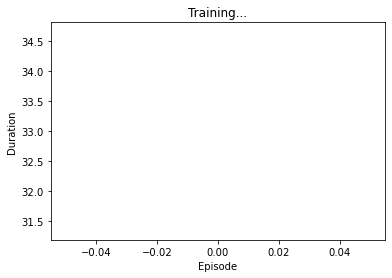

ERROR: VideoRecorder encoder exited with status 1
 Episode 1 finished after 18 steps


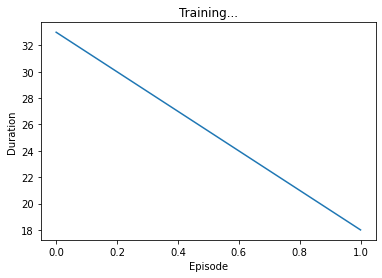

ERROR: VideoRecorder encoder exited with status 1
 Episode 2 finished after 18 steps


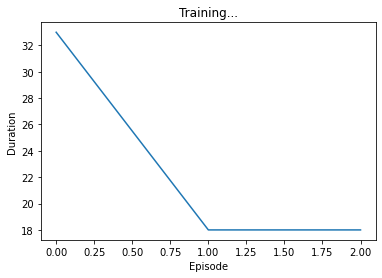

 Episode 3 finished after 14 steps


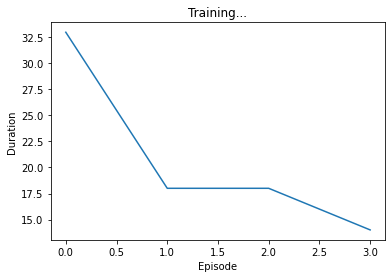

 Episode 4 finished after 15 steps


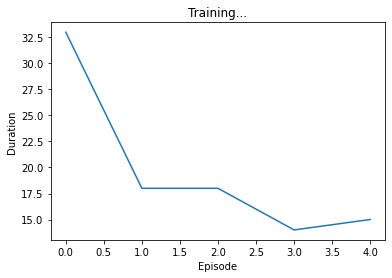

 Episode 5 finished after 10 steps


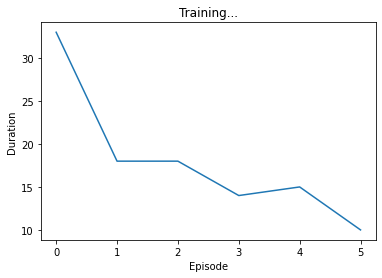

 Episode 6 finished after 11 steps


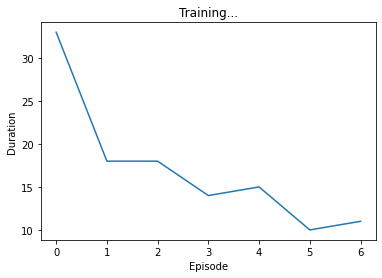

 Episode 7 finished after 12 steps


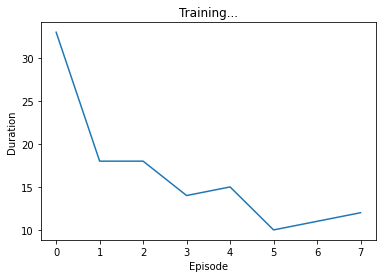

 Episode 8 finished after 13 steps


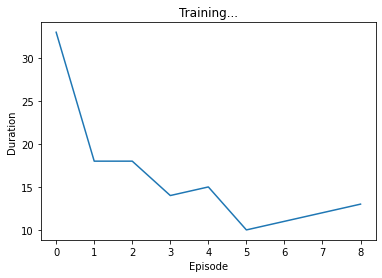

ERROR: VideoRecorder encoder exited with status 1
 Episode 9 finished after 12 steps


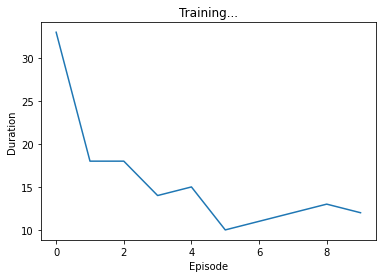

 Episode 10 finished after 11 steps


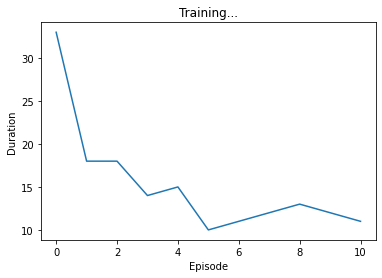

 Episode 11 finished after 11 steps


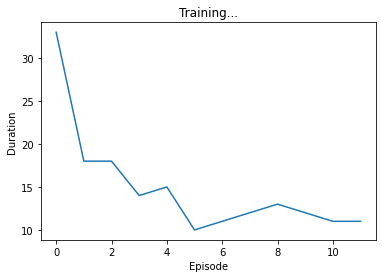

 Episode 12 finished after 11 steps


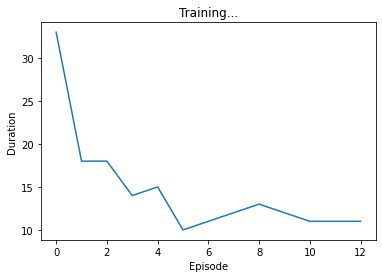

 Episode 13 finished after 12 steps


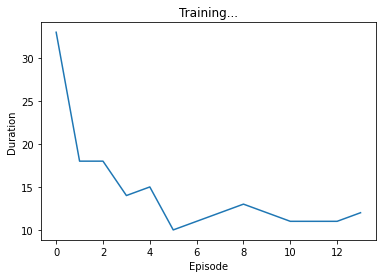

 Episode 14 finished after 14 steps


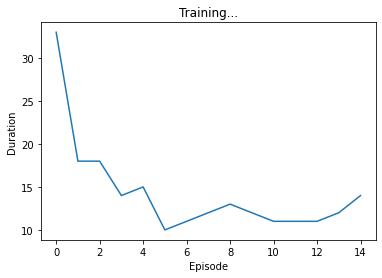

 Episode 15 finished after 10 steps


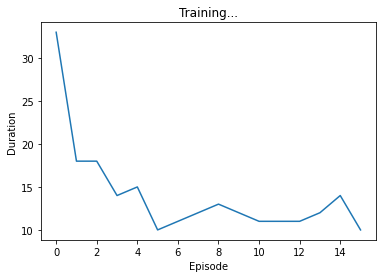

 Episode 16 finished after 8 steps


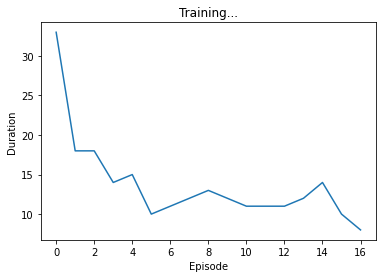

 Episode 17 finished after 11 steps


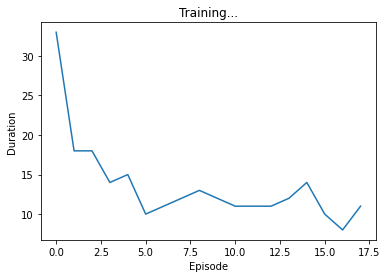

 Episode 18 finished after 15 steps


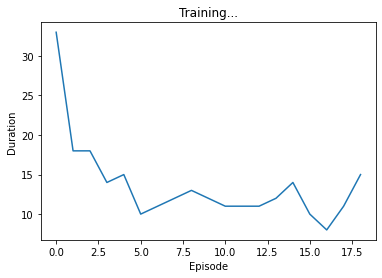

 Episode 19 finished after 18 steps


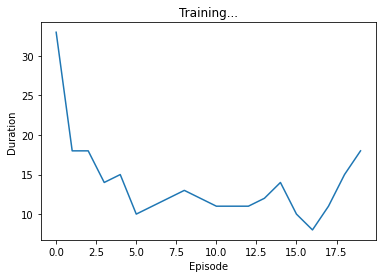

 Episode 20 finished after 14 steps


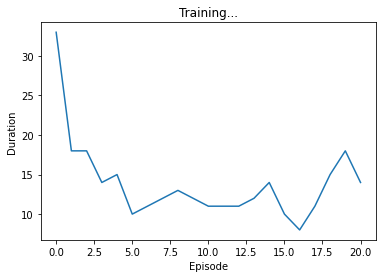

 Episode 21 finished after 16 steps


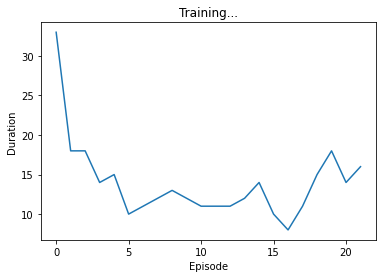

 Episode 22 finished after 22 steps


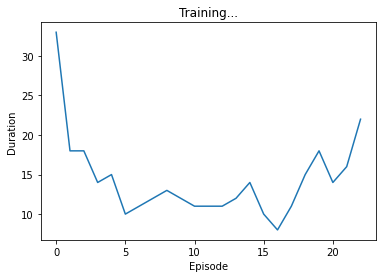

 Episode 23 finished after 14 steps


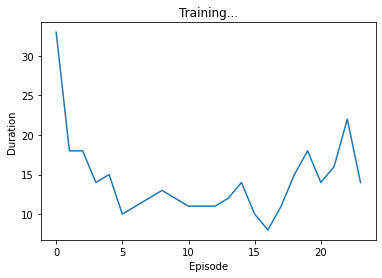

 Episode 24 finished after 20 steps


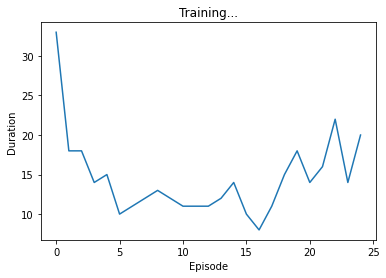

 Episode 25 finished after 13 steps


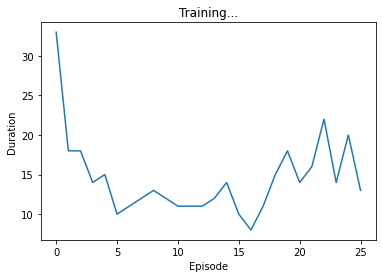

 Episode 26 finished after 27 steps


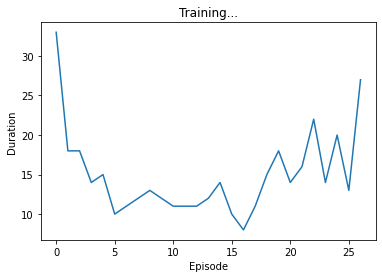

 Episode 27 finished after 35 steps


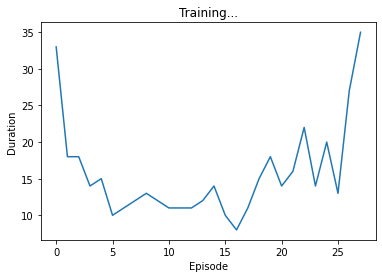

ERROR: VideoRecorder encoder exited with status 1
 Episode 28 finished after 25 steps


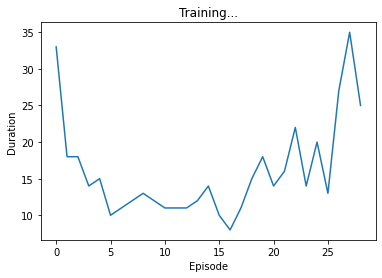

 Episode 29 finished after 31 steps


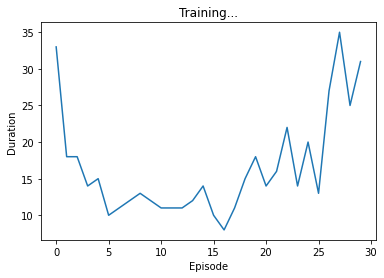

 Episode 30 finished after 88 steps


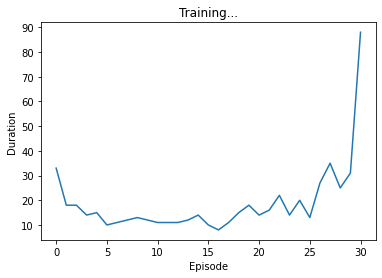

 Episode 31 finished after 108 steps


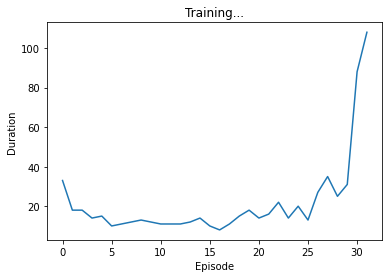

 Episode 32 finished after 134 steps


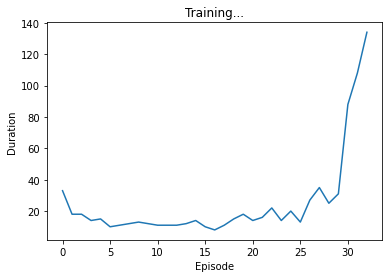

 Episode 33 finished after 124 steps


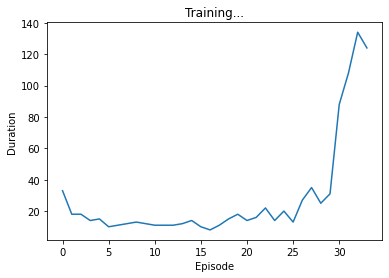

 Episode 34 finished after 121 steps


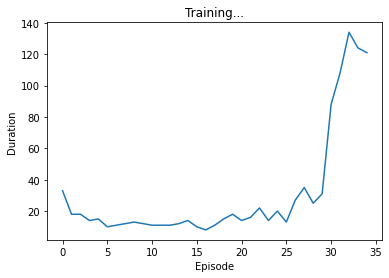

 Episode 35 finished after 89 steps


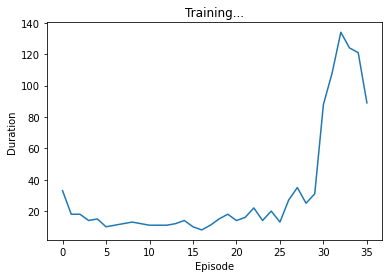

 Episode 36 finished after 79 steps


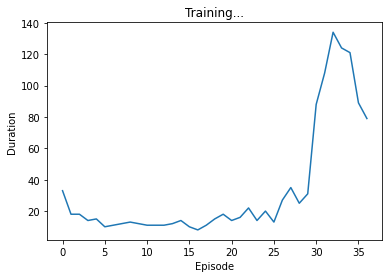

 Episode 37 finished after 134 steps


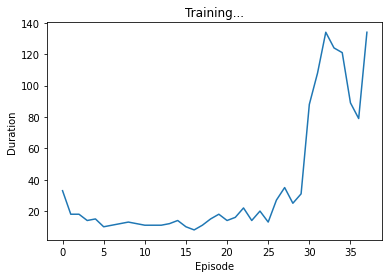

 Episode 38 finished after 104 steps


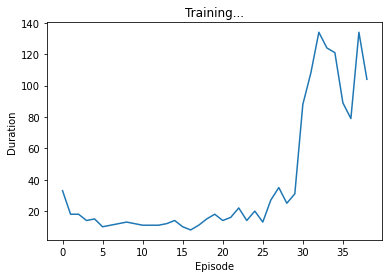

 Episode 39 finished after 109 steps


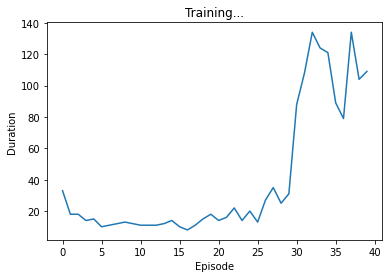

 Episode 40 finished after 99 steps


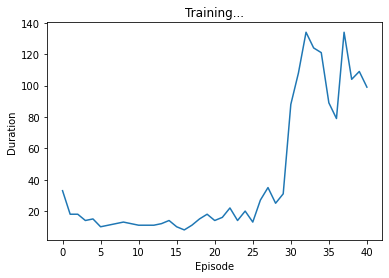

 Episode 41 finished after 139 steps


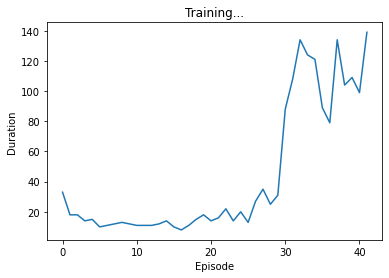

 Episode 42 finished after 114 steps


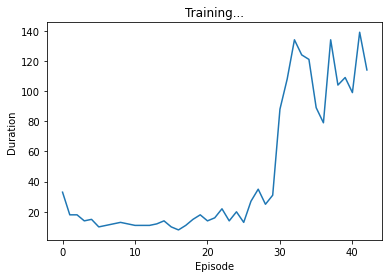

 Episode 43 finished after 167 steps


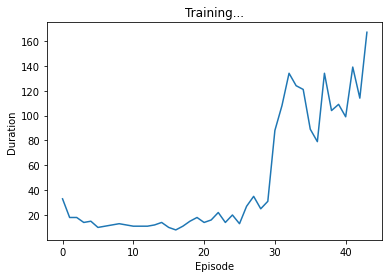

 Episode 44 finished after 172 steps


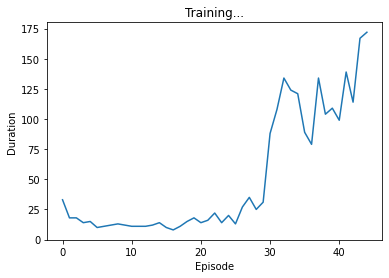

 Episode 45 finished after 131 steps


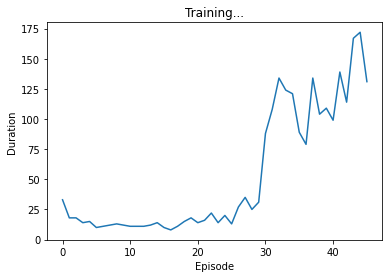

 Episode 46 finished after 117 steps


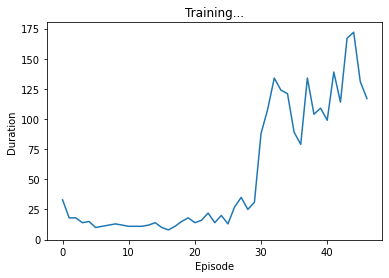

 Episode 47 finished after 111 steps


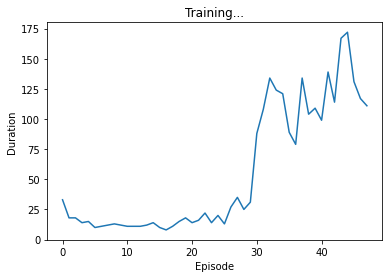

 Episode 48 finished after 132 steps


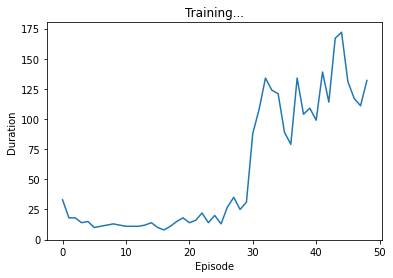

 Episode 49 finished after 200 steps


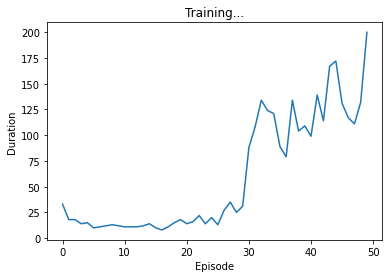

 Episode 50 finished after 146 steps


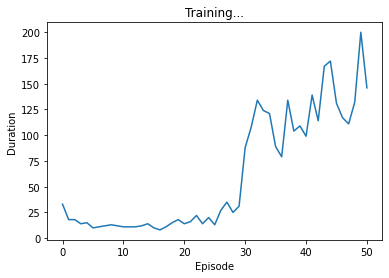

 Episode 51 finished after 161 steps


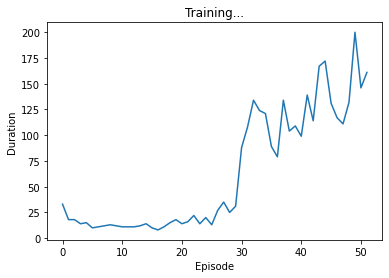

 Episode 52 finished after 200 steps


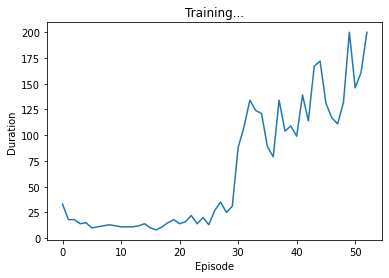

 Episode 53 finished after 200 steps


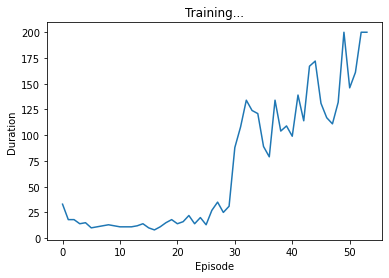

 Episode 54 finished after 174 steps


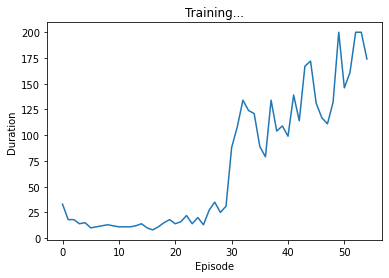

 Episode 55 finished after 200 steps


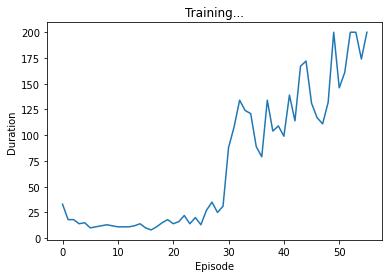

 Episode 56 finished after 164 steps


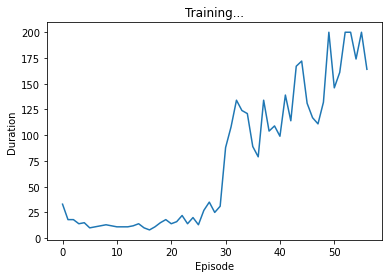

 Episode 57 finished after 200 steps


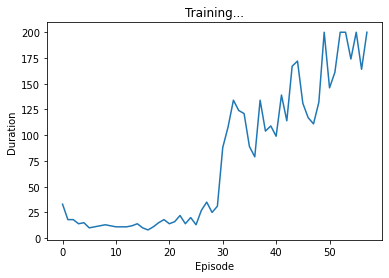

 Episode 58 finished after 199 steps


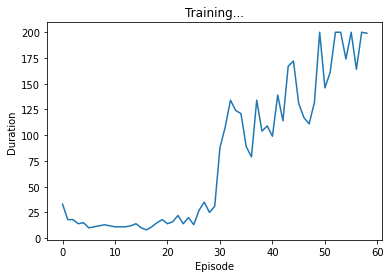

 Episode 59 finished after 200 steps


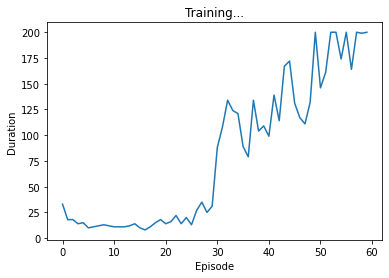

 Episode 60 finished after 200 steps


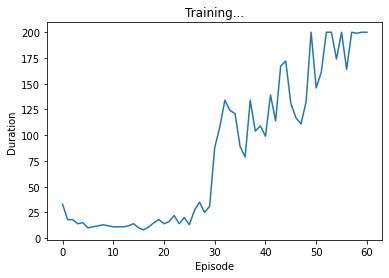

 Episode 61 finished after 188 steps


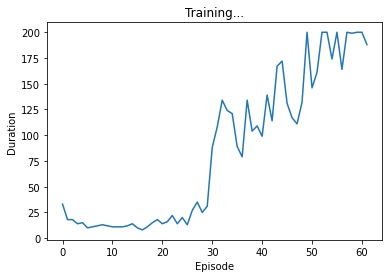

 Episode 62 finished after 153 steps


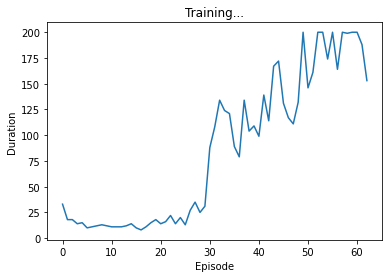

 Episode 63 finished after 200 steps


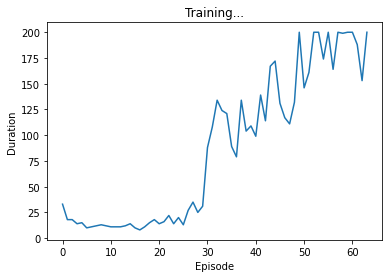

 Episode 64 finished after 200 steps


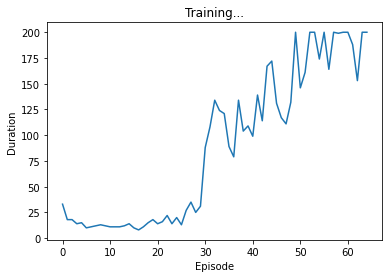

ERROR: VideoRecorder encoder exited with status 1
 Episode 65 finished after 151 steps


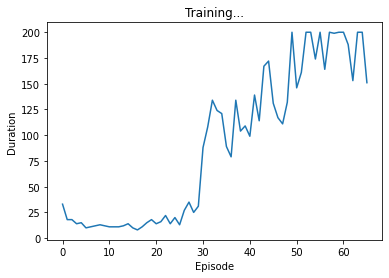

 Episode 66 finished after 200 steps


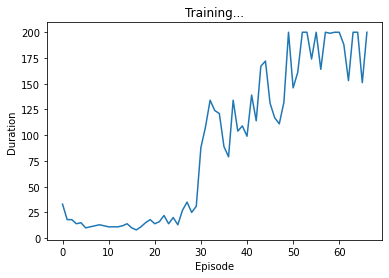

 Episode 67 finished after 154 steps


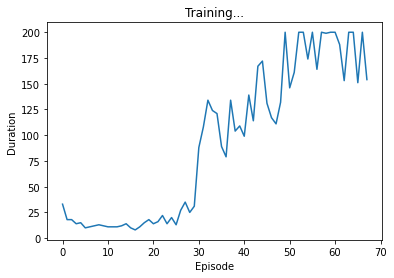

 Episode 68 finished after 168 steps


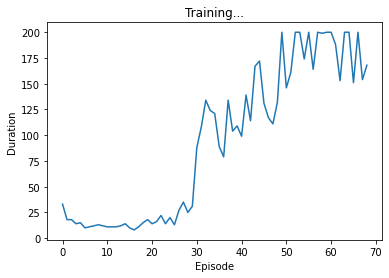

 Episode 69 finished after 175 steps


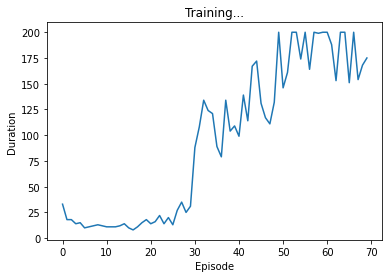

 Episode 70 finished after 185 steps


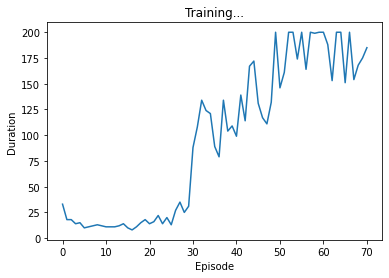

 Episode 71 finished after 140 steps


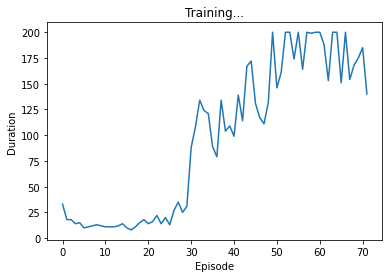

 Episode 72 finished after 186 steps


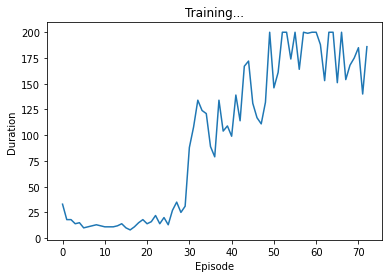

 Episode 73 finished after 93 steps


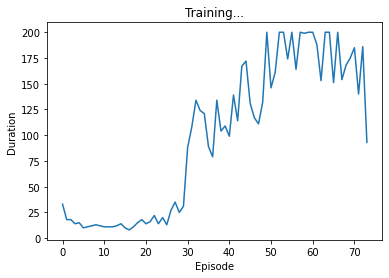

 Episode 74 finished after 200 steps


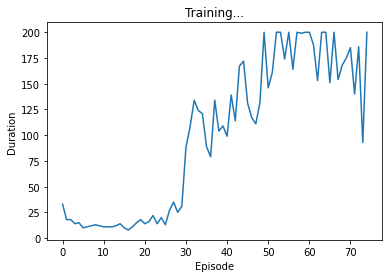

 Episode 75 finished after 200 steps


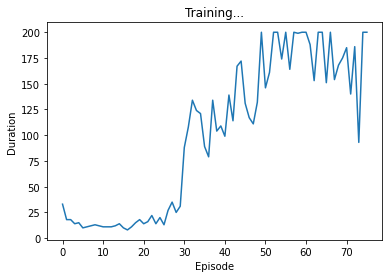

 Episode 76 finished after 200 steps


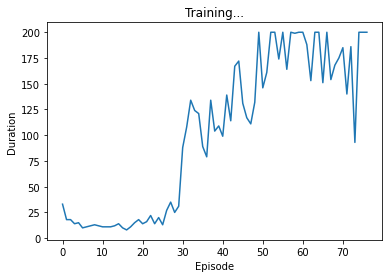

 Episode 77 finished after 200 steps


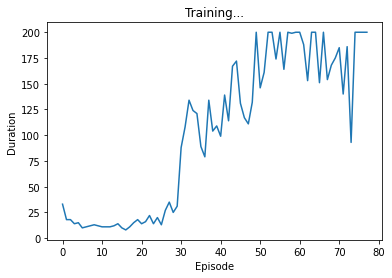

 Episode 78 finished after 200 steps


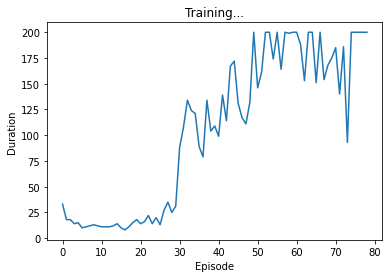

 Episode 79 finished after 161 steps


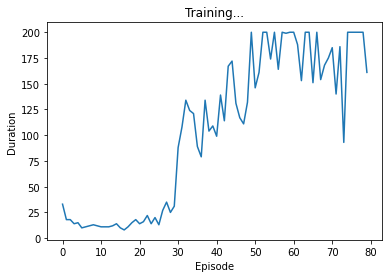

 Episode 80 finished after 200 steps


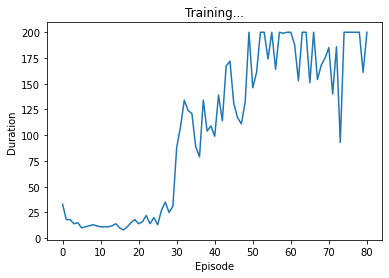

 Episode 81 finished after 196 steps


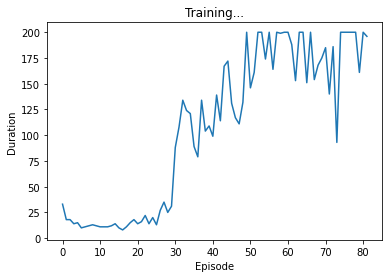

 Episode 82 finished after 188 steps


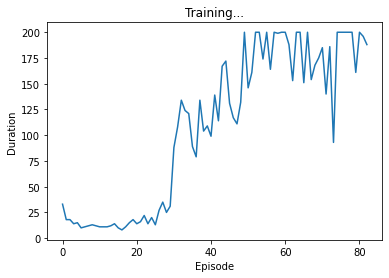

 Episode 83 finished after 149 steps


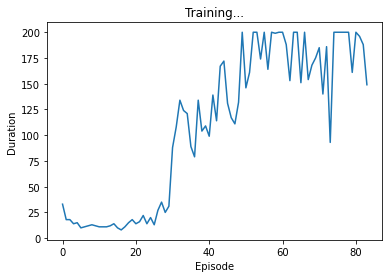

 Episode 84 finished after 176 steps


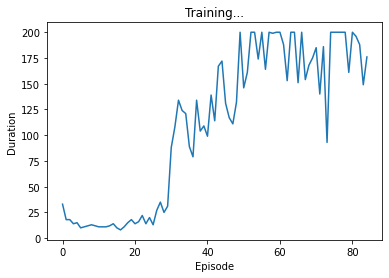

 Episode 85 finished after 200 steps


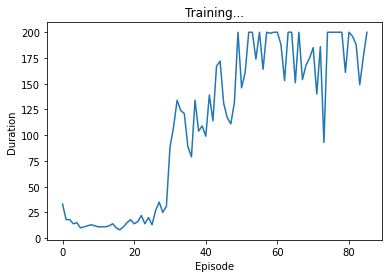

 Episode 86 finished after 189 steps


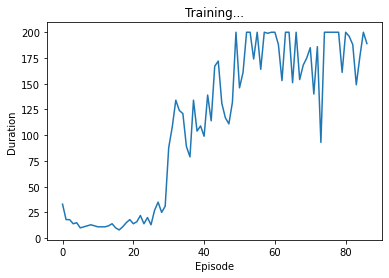

 Episode 87 finished after 200 steps


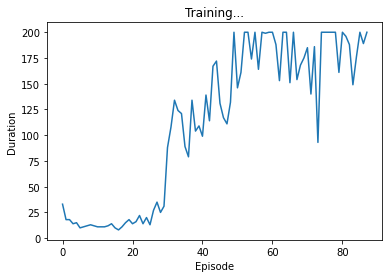

 Episode 88 finished after 152 steps


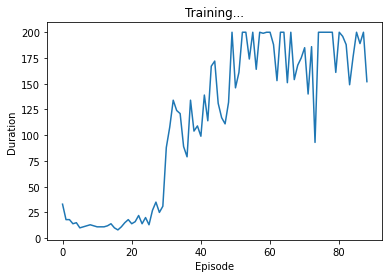

 Episode 89 finished after 173 steps


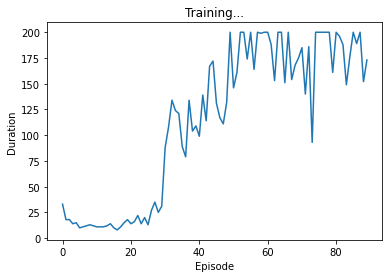

 Episode 90 finished after 180 steps


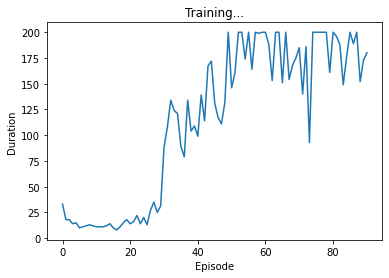

 Episode 91 finished after 188 steps


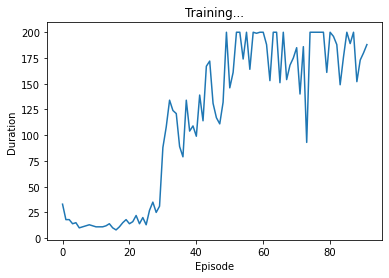

 Episode 92 finished after 183 steps


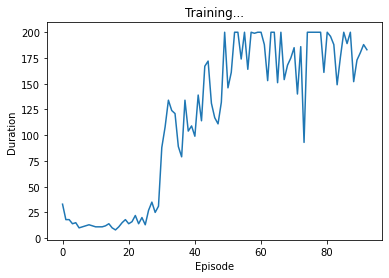

 Episode 93 finished after 180 steps


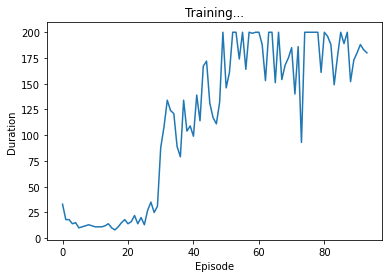

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/kandemir/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-a49633a253e6>", line 2, in <module>
    run_episode(e, env)
  File "<ipython-input-6-eb261b918653>", line 5, in run_episode
    environment.render()
  File "/Users/kandemir/opt/anaconda3/lib/python3.8/site-packages/gym/core.py", line 240, in render
    return self.env.render(mode, **kwargs)
  File "/Users/kandemir/opt/anaconda3/lib/python3.8/site-packages/gym/core.py", line 240, in render
    return self.env.render(mode, **kwargs)
  File "/Users/kandemir/opt/anaconda3/lib/python3.8/site-packages/gym/envs/classic_control/cartpole.py", line 213, in render
    return self.viewer.render(return_rgb_array=mode == 'rgb_array')
  File "/Users/kandemir/opt/anaconda3/lib/python3.8/site-packages/gym/envs/classic_control/rendering.py", line 127, in render
    self

TypeError: object of type 'NoneType' has no len()

In [9]:
for e in range(EPISODES):
    run_episode(e, env)

print('Complete')
env.render(close=True)
env.close()
plt.ioff()
plt.show()